<ins>Logical Workflow PA Project</ins>

0. Call Data from SQL Server and save to local .pkl. Filter by TBM 1 and time span ('2022/02/01', '2022/04/01')
1. Join data for a complete dataset
2. Initial Filter (by Equipment ID: TBM 1 and remove Trial Recipes), key generation, cycle time generation and EDA
3. Left Merge Alarm mapping and Alarm hisroy on Created Key.
4. Alarm Discovery: Alarm to GT allocation: Calculate PAAP start and finish times if needed. Do NOT Filter alarms by Type e.g.  FF, CF and MC, assin name in#dexes. Link these alarm name indexes that are occurring for the same green tire at those times identified as PA. Create GT to Alarm Index Mapping.
5. One Hot encode Alarm Indexes before we carry out feature selction to see relevant alarms.
6. Feature selection: Initial Filter using statistical univariate filter methods. 
7. Feature selection: Narrow down using ML Models. Identify which steps are posing the issue (i.e. is it sidewall, inner liner, is it transport time etc.)


In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
from helpers import TBM, bcolors, Data_Functions
import matplotlib.pyplot as plt

DF = Data_Functions()
TBM = TBM()
p = bcolors()

In [2]:
df_alarm_join = pd.read_pickle("./pkl/alarms_join.pkl") # Joined alarms with name index
df_tbm = pd.read_pickle("./pkl/df_tbm_PAAP_times.pkl")  # Production data with PAAP times

In [3]:
df_alarm_join

,key,Name,Type,MessageID_x,HistoryMessageID,TimeStamp,Duration,EquipmentID,name_index,alarm_start
0,89031TBM_1,MOTION COMMUNICATION FAILURE CARCASS SIDE,FF,89031,21906293,2022-03-25 03:06:38.3988765,4,TBM 1,0,2022-03-25 03:06:34.398876500
1,89031TBM_1,MOTION COMMUNICATION FAILURE CARCASS SIDE,FF,89031,21337964,2022-02-27 11:32:38.1855400,4,TBM 1,0,2022-02-27 11:32:34.185540000
2,89031TBM_1,MOTION COMMUNICATION FAILURE CARCASS SIDE,FF,89031,21017480,2022-02-11 09:42:28.6704247,7,TBM 1,0,2022-02-11 09:42:21.670424700
3,89031TBM_1,MOTION COMMUNICATION FAILURE CARCASS SIDE,FF,89031,21018750,2022-02-11 11:10:13.6504815,4,TBM 1,0,2022-02-11 11:10:09.650481500
5,89031TBM_1,MOTION COMMUNICATION FAILURE CARCASS SIDE,FF,89031,22525429,2022-04-27 15:08:19.1819223,7,TBM 1,0,2022-04-27 15:08:12.181922300
...,...,...,...,...,...,...,...,...,...,...
1347317,97567TBM_1,???,OM,97567,22618603,2022-05-04 04:03:30.7745552,14,TBM 1,1018,2022-05-04 04:03:16.774555200
1347318,97567TBM_1,???,OM,97567,22495750,2022-04-25 21:30:33.4923961,23,TBM 1,1018,2022-04-25 21:30:10.492396100
1347319,97567TBM_1,???,OM,97567,22474746,2022-04-24 19:40:02.4974760,28,TBM 1,1018,2022-04-24 19:39:34.497476000
1347320,97567TBM_1,???,OM,97567,22474770,2022-04-24 19:41:43.7408270,58,TBM 1,1018,2022-04-24 19:40:45.740827000


In [4]:
df_gt_to_alarm = TBM.allocator(df_alarms=df_alarm_join, df_cycle=df_tbm, df_cycle_end='PAAP_Finish_time', df_cycle_start='PAAP_Start_time', alarm_timestamp = 'alarm_start')

In [5]:
mask = df_gt_to_alarm.list_of_alarms.apply(lambda x:  len(x) != 0)
df1 = df_gt_to_alarm[mask]
print (df1)

              Id   list_of_alarms
1       11141586       [327, 926]
3       11141590            [927]
4       11141591            [926]
6       11141640       [522, 926]
7       11141641  [242, 522, 926]
...          ...              ...
110212  12464393            [242]
110213  12464394            [242]
110214  12464395            [926]
110215  12464396            [926]
110218  12464465       [926, 927]

[66214 rows x 2 columns]


In [6]:
df_gt_to_alarm.to_pickle("./pkl/pa_alarm_map_to_gt.pkl")

In [7]:
df1.to_pickle("./pkl/non_empty_pa_alarm_map_to_gt.pkl")


Aggregate by Recipe.

In [8]:
df_tbm[['RecipeName', 'Id']]

,RecipeName,Id
0,GG224517HYPXY,11141585
1,GG224517HYPXY,11141586
2,GG224517HYPXY,11141588
3,GG224517HYPXY,11141590
4,GG224517HYPXY,11141591
...,...,...
110579,GG215017ULAXY,12467918
110580,GG215017ULAXY,12467919
110581,GG215017ULAXY,12467920
110582,GG215017ULAXY,12468000


In [9]:
filter_alarms_recipe = pd.merge(df_tbm[['RecipeName', 'Id']],df_gt_to_alarm,on='Id')
filter_alarms_recipe

,RecipeName,Id,list_of_alarms
0,GG224517HYPXY,11141585,[]
1,GG224517HYPXY,11141586,"[327, 926]"
2,GG224517HYPXY,11141588,[]
3,GG224517HYPXY,11141590,[927]
4,GG224517HYPXY,11141591,[926]
...,...,...,...
110579,GG215017ULAXY,12467918,[]
110580,GG215017ULAXY,12467919,[]
110581,GG215017ULAXY,12467920,[]
110582,GG215017ULAXY,12468000,[]


In [10]:
recipe_size = filter_alarms_recipe.groupby(['RecipeName']).size()
recipe_size

RecipeName
GG204017QPRXW     639
GG204017ULAXY     782
GG204517HYPNY     108
GG204517QPRXY    3585
GG204517QT5XY     700
                 ... 
GG244017HYPNY     381
GG244017ULAXY     769
GG244517ULAXY    1126
GG256017QT5NV    2589
GG266517QPRXH     835
Length: 76, dtype: int64

In [11]:
recipe_alarm_map = filter_alarms_recipe.groupby('RecipeName').agg({'list_of_alarms': 'sum'})
recipe_alarm_map

,list_of_alarms
RecipeName,
GG204017QPRXW,"[53, 56, 58, 58, 313, 345, 368, 407, 414, 681,..."
GG204017ULAXY,"[303, 681, 968, 1006, 529, 681, 921, 399, 968,..."
GG204517HYPNY,"[183, 205, 215, 180, 692, 920, 242, 692, 926, ..."
GG204517QPRXY,"[681, 692, 968, 681, 692, 708, 806, 870, 918, ..."
GG204517QT5XY,"[47, 114, 114, 136, 332, 407, 438, 524, 526, 5..."
...,...
GG244017HYPNY,"[681, 870, 915, 921, 951, 965, 968, 1005, 1006..."
GG244017ULAXY,"[52, 995, 242, 926, 892, 74, 125, 892, 926, 24..."
GG244517ULAXY,"[52, 114, 59, 136, 681, 683, 815, 870, 915, 92..."


In [12]:
recipe_alarm_map['number_of_alarms'] = recipe_alarm_map.list_of_alarms.apply(lambda x: len(x))
recipe_alarm_map

,list_of_alarms,number_of_alarms
RecipeName,,
GG204017QPRXW,"[53, 56, 58, 58, 313, 345, 368, 407, 414, 681,...",1325
GG204017ULAXY,"[303, 681, 968, 1006, 529, 681, 921, 399, 968,...",848
GG204517HYPNY,"[183, 205, 215, 180, 692, 920, 242, 692, 926, ...",223
GG204517QPRXY,"[681, 692, 968, 681, 692, 708, 806, 870, 918, ...",3358
GG204517QT5XY,"[47, 114, 114, 136, 332, 407, 438, 524, 526, 5...",588
...,...,...
GG244017HYPNY,"[681, 870, 915, 921, 951, 965, 968, 1005, 1006...",783
GG244017ULAXY,"[52, 995, 242, 926, 892, 74, 125, 892, 926, 24...",999
GG244517ULAXY,"[52, 114, 59, 136, 681, 683, 815, 870, 915, 92...",1111


In [13]:
recipe_alarm_map['num_gt'] = filter_alarms_recipe.groupby(['RecipeName']).size()

In [14]:
recipe_alarm_map

,list_of_alarms,number_of_alarms,num_gt
RecipeName,,,
GG204017QPRXW,"[53, 56, 58, 58, 313, 345, 368, 407, 414, 681,...",1325,639
GG204017ULAXY,"[303, 681, 968, 1006, 529, 681, 921, 399, 968,...",848,782
GG204517HYPNY,"[183, 205, 215, 180, 692, 920, 242, 692, 926, ...",223,108
GG204517QPRXY,"[681, 692, 968, 681, 692, 708, 806, 870, 918, ...",3358,3585
GG204517QT5XY,"[47, 114, 114, 136, 332, 407, 438, 524, 526, 5...",588,700
...,...,...,...
GG244017HYPNY,"[681, 870, 915, 921, 951, 965, 968, 1005, 1006...",783,381
GG244017ULAXY,"[52, 995, 242, 926, 892, 74, 125, 892, 926, 24...",999,769
GG244517ULAXY,"[52, 114, 59, 136, 681, 683, 815, 870, 915, 92...",1111,1126


In [15]:
recipe_alarm_map['numner_PA_Alarm_per_GT'] = recipe_alarm_map['number_of_alarms'] / recipe_alarm_map['num_gt']

In [16]:
recipe_alarm_map

,list_of_alarms,number_of_alarms,num_gt,numner_PA_Alarm_per_GT
RecipeName,,,,
GG204017QPRXW,"[53, 56, 58, 58, 313, 345, 368, 407, 414, 681,...",1325,639,2.073552
GG204017ULAXY,"[303, 681, 968, 1006, 529, 681, 921, 399, 968,...",848,782,1.084399
GG204517HYPNY,"[183, 205, 215, 180, 692, 920, 242, 692, 926, ...",223,108,2.064815
GG204517QPRXY,"[681, 692, 968, 681, 692, 708, 806, 870, 918, ...",3358,3585,0.936681
GG204517QT5XY,"[47, 114, 114, 136, 332, 407, 438, 524, 526, 5...",588,700,0.840000
...,...,...,...,...
GG244017HYPNY,"[681, 870, 915, 921, 951, 965, 968, 1005, 1006...",783,381,2.055118
GG244017ULAXY,"[52, 995, 242, 926, 892, 74, 125, 892, 926, 24...",999,769,1.299090
GG244517ULAXY,"[52, 114, 59, 136, 681, 683, 815, 870, 915, 92...",1111,1126,0.986679


In [17]:
recipe_alarm_map.to_pickle('recipe_alarm_map.pkl')

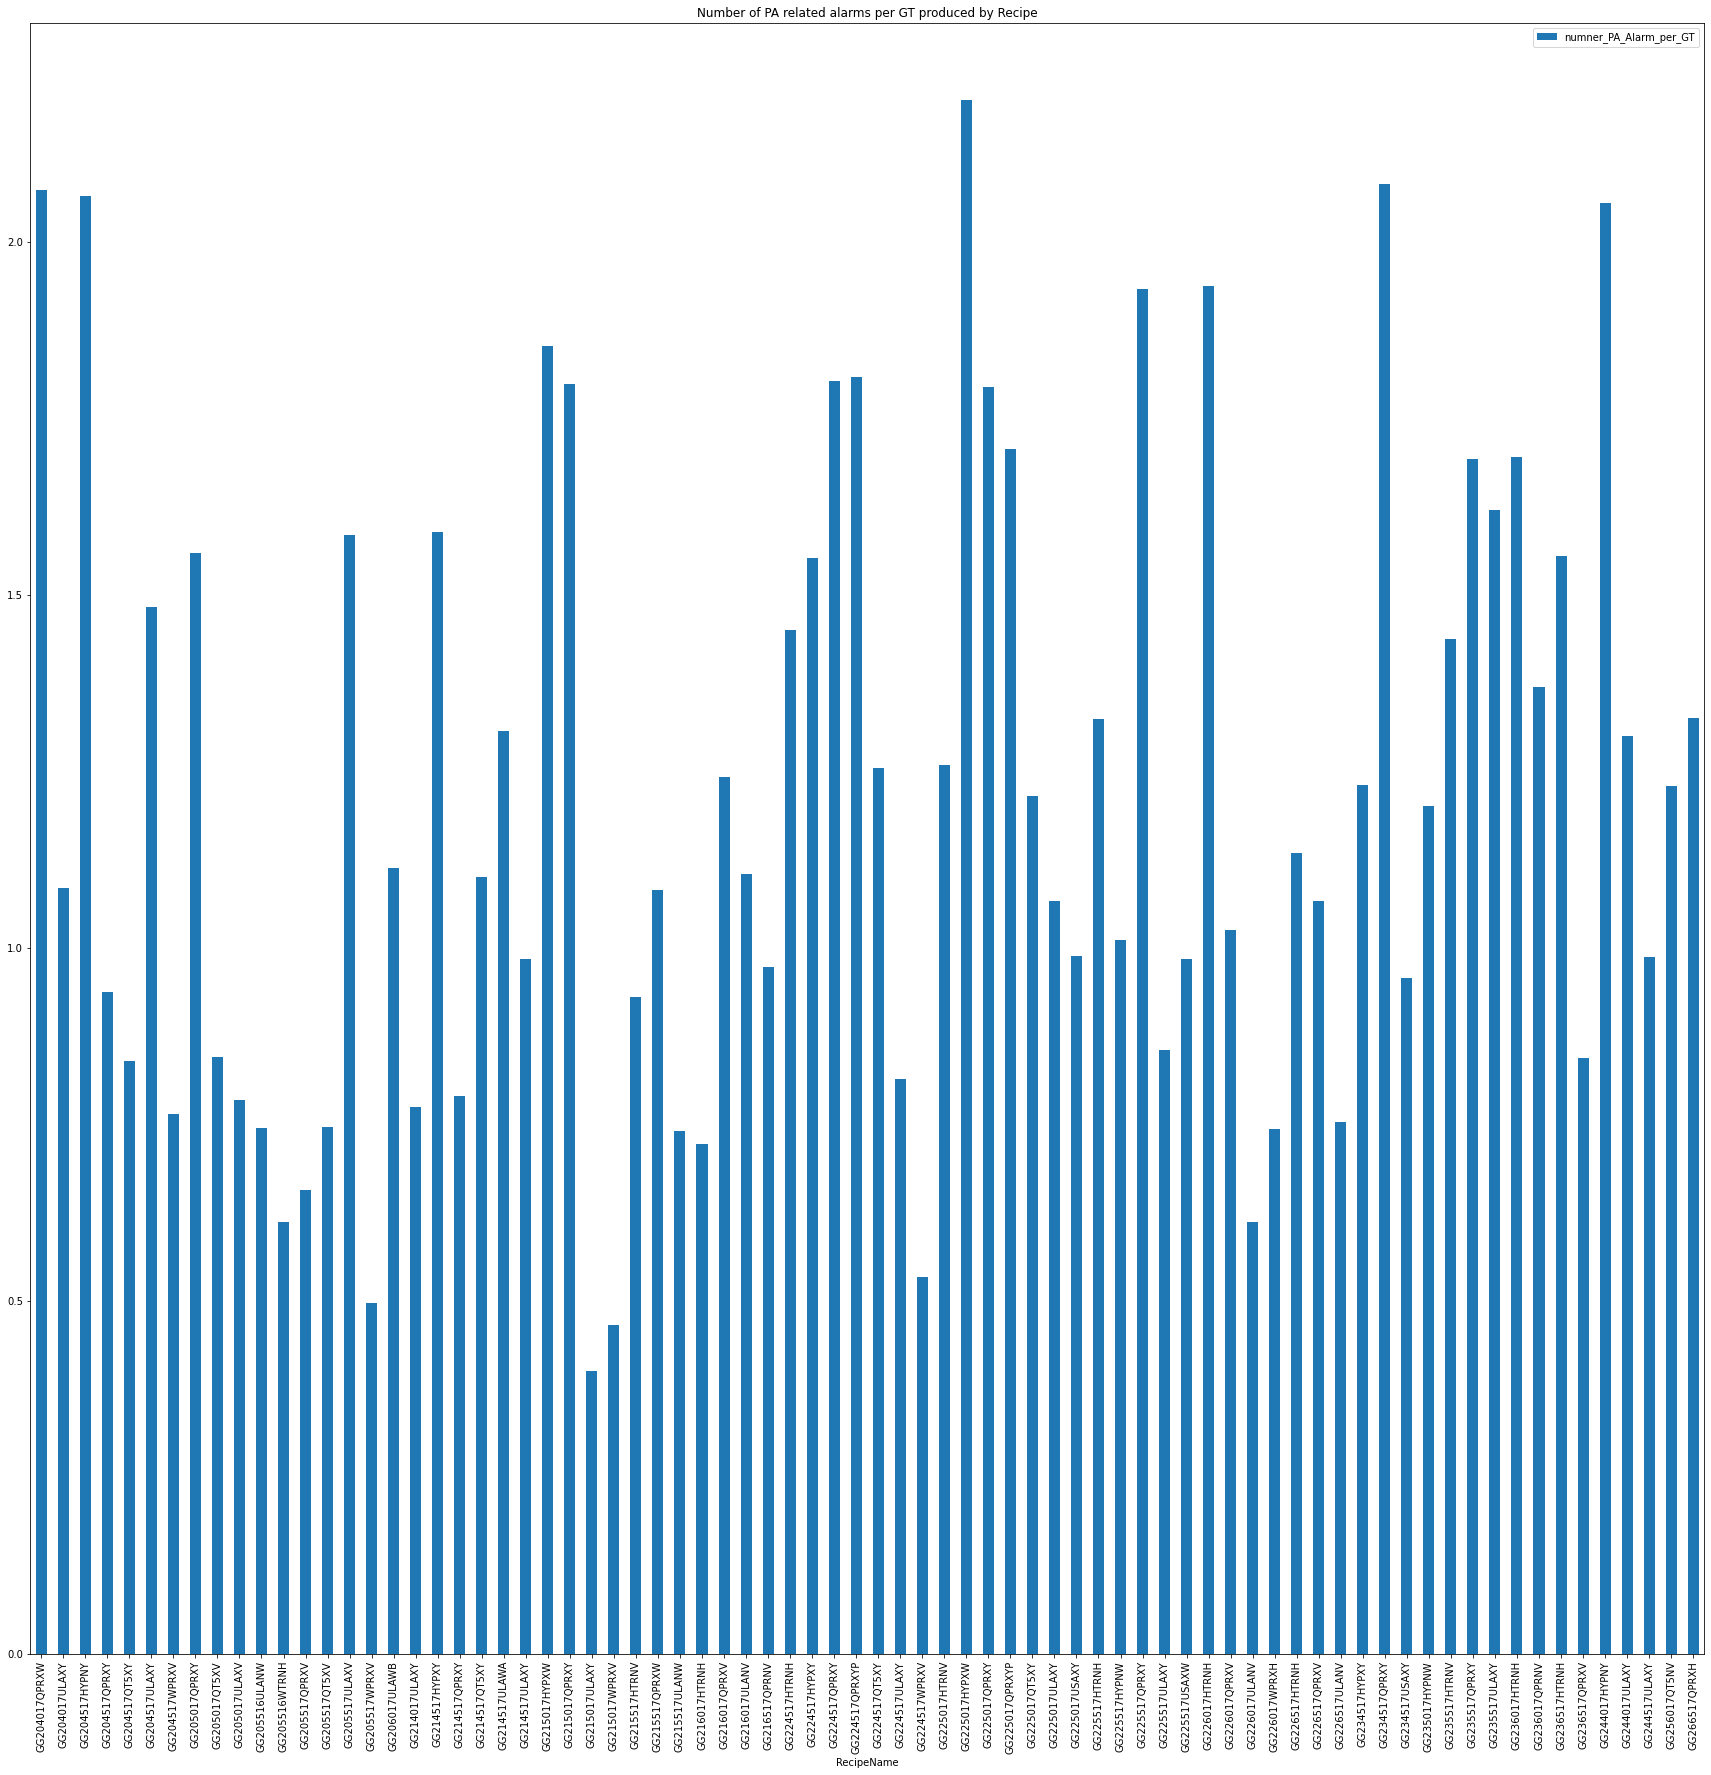

In [18]:
ax = recipe_alarm_map.plot.bar(y='numner_PA_Alarm_per_GT', rot=90, use_index=True, figsize=(30,30), title='Number of PA related alarms per GT produced by Recipe')

computes the Z-score of each value in the column calcukated, relative to the column mean and standard deviation.

It then takes the absolute Z-score because the direction does not matter, only if it is below the threshold.

all(axis=1) ensures that for each row, all column satisfy the constraint.

Finally, the result of this condition is used to index the dataframe.

In [20]:
from scipy import stats
recipe_alarm_map[(np.abs(stats.zscore(recipe_alarm_map['numner_PA_Alarm_per_GT'])) > 3)]

,list_of_alarms,number_of_alarms,num_gt,numner_PA_Alarm_per_GT
RecipeName,,,,


Conclude, no outliers by Recipe

In [21]:
recipe_alarm_map.to_pickle("./pkl/recipe_alarm_map_filtered.pkl")